### Analyzing Cog Sci abstract data
March 4, 2018

This notebook grabs the cogsci proceedings data and does the following.

###### LSA:
- pre-processing: creates tf-idf representation of each abstract.
- analysis: performs Latent Semantic Analysis (truncated SVD) using gensim for latent space document and term representation.
- clustering: hierarchical clustering, t-SNE, PCA?

###### word2vec:
- skip-gram/cbow pre-processing
- build word2vec model using gensim for word meaning vectors



LATER: build doc2vec model using gensim for doc meaning

All analyses are first done with only cognitive key words for a sparse but cognition-specific model, then it's repeated with all words for a fuller dataset.

In [272]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import gensim as gs
from sklearn import decomposition, metrics, cluster
import matplotlib.pyplot as plt

### function defs

In [175]:
def corpus_from_list(doc_list, terms_dict=None):
    # transform doc_list, which is a list of strings where each string is a document, into gensim friendly corpus form
    # are you f-ing serious I have to build the corpus feature myself..?
    terms = term_dict.keys()
    corpus_index = [None]*len(doc_list)
    corpus_terms = [None]*len(doc_list)
    for doc_ind, doc in enumerate(doc_list):
        cur_corp_index = []
        cur_corp_terms = []
        for term in terms:
            # use all lower case to search
            t_count = doc.lower().count(term)
            if t_count:
                cur_corp_index.append((term_dict[term], t_count))
                cur_corp_terms.append(term)
                
        corpus_index[doc_ind] = cur_corp_index
        corpus_terms[doc_ind] = cur_corp_terms
    
    return corpus_index, corpus_terms

def terms_similar_to(term_sim, dictionary, query_term='attention', topN=10):
    # querying top N similar words
    if query_term in dictionary.token2id.keys():
        query_ind = dictionary.token2id[query_term]
        print('Freq. | Similarity: Term')
        print('------------------------')
        for i in np.argsort(term_sim[query_ind,:])[::-1][:topN]:
            print('%.3f | %.3f: '%(dictionary.dfs[i]/dictionary.num_docs, term_sim[query_ind,i]) + dictionary.id2token[i])
            
    else:
        print(query_term + ' is not in the dictionary.')

In [3]:
# import dictionary (cognitive concept word list)
terms_file = '../data/cogatlas_terms.txt'
terms = pd.read_csv(terms_file, delimiter='\n', names=['Terms'])

# construct as dictionary
# gensim requires dict to be of form {'word':id}, so zip together term list and id numbers
term_dict = dict(zip(terms['Terms'], range(len(terms['Terms'])))) 

# import data as pd dataframe
abstract_file = '../data/cogsci_abstracts.csv'
col_names = ('Year', 'Title', 'Abstract', 'Authors', 'Affiliations', 'URL')
df_cs = pd.read_csv(abstract_file, header=None, names=col_names)
print('%i documents extracted.' %len(df_cs))

6385 documents extracted.


In [4]:
# combine title & abstract of each document and put into list
doc_list = []
for t in range(len(df_cs)):
    if type(df_cs['Abstract'][t]) is not str:
        doc_list.append(df_cs['Title'][t])
    else:
        doc_list.append(df_cs['Title'][t]+'. ' + df_cs['Abstract'][t])    
        
# convert document list into dictionary-words only list, by using the custom dictionary.
# if using the whole corpus to build dictionary, just do 
#     dct = gs.corpora.Dictionary([d.lower() for d in doc_list.lower])
print('Pruning document list for dictionary words only...')
corpus_index, corpus_terms = corpus_from_list(doc_list=doc_list, terms_dict=term_dict)

Pruning document list for dictionary words only...


### Latent Semantic Analysis
https://en.wikipedia.org/wiki/Latent_semantic_analysis#Derivation

###### tf-idf model
Some questions:
- is it necessary to stem the keywords/data?
- how best to handle phrases where sub-phrases are also dict phrases ("memory" in "working memory", "concept" in "conceptual)? (https://stackoverflow.com/questions/4173787/string-exact-match/4173810)

In [5]:
# building tf-idf representation

# use gensim to rebuild dictionary, though now the original dictionary that 
# I build (term_dict) will have different indices than the gensim dict (dct), which
# is fine, just need to be careful with indexing and not use the original dict
dct = gs.corpora.Dictionary(corpus_terms)
print(dct)
corpus = [dct.doc2bow(line) for line in corpus_terms]
model = gs.models.TfidfModel(corpus, id2word=dct)  # fit model
corpus_tfidf = [model[c] for c in corpus]

Dictionary(516 unique tokens: ['concept', 'focus', 'goal', 'learning', 'search']...)


In [6]:
# train LSA model using tfidf
model = gs.models.lsimodel.LsiModel(corpus_tfidf, id2word=dct, num_topics=20)
model.print_topics(20)
# put topic vectors into a pandas df
df = pd.DataFrame([[t[0]+" %.3f" %t[1] for t in model.show_topic(i)] for i in range(model.num_topics)])
#df
index = gs.similarities.MatrixSimilarity(model[corpus_tfidf])

### Fun little query to show document similarity
Looks like document similarity is pretty good! Though this wasn't even what I wanted to get at...

In [100]:
print_abstr=False
doc_num = 100#np.random.randint(len(corpus_tfidf))
topN = 5
doc_sim = sorted(enumerate(index[model[corpus_tfidf[doc_num]]]), key=lambda item: -item[1])
print(doc_num)
for i in range(topN+1):
    print('---%i---'%i)
    print(df_cs['Title'][doc_sim[i][0]])
    if print_abstr: print(df_cs['Abstract'][doc_sim[i][0]])

100
---0---
Children’s social referencing reflects sensitivity to graded uncertainty
---1---
Social and Environmental Contributors to Infant Word Learning
---2---
What role do you play in group activity? Objective evaluation through third parties
---3---
Narrowing of the Cone-of-Direct Gaze Through Reinforcement Learning
---4---
Online Processing of Speech and Social Information in Early Word Learning
---5---
How does this thing work? Evaluating computational models of intervention-based causal learning


In [271]:
# word frequency
for t in np.argsort([dct.dfs[t] for t in range(len(dct.dfs))])[::-1]:    
    print('%.3f: '%(dct.dfs[t]/dct.num_docs) + dct.id2token[t])

0.257: learning
0.228: search
0.215: action
0.184: language
0.151: logic
0.126: knowledge
0.125: concept
0.121: memory
0.117: context
0.101: decision
0.089: attention
0.082: reasoning
0.080: judgment
0.079: focus
0.075: lying
0.073: inference
0.073: perception
0.071: meaning
0.061: goal
0.058: movement
0.053: recognition
0.047: reading
0.046: skill
0.044: belief
0.043: strategy
0.042: rule
0.038: emotion
0.038: association
0.037: communication
0.036: categorization
0.032: insight
0.032: working memory
0.032: thought
0.032: activation
0.028: recall
0.028: strength
0.026: resource
0.026: priming
0.026: intention
0.026: manipulation
0.025: decision making
0.025: problem solving
0.025: generalization
0.024: uncertainty
0.023: gaze
0.022: integration
0.021: conversation
0.021: effort
0.021: encoding
0.020: retrieval
0.020: detection
0.020: fixation
0.019: category learning
0.018: valence
0.018: metaphor
0.017: risk
0.017: coordination
0.016: discourse
0.016: eating
0.016: interference
0.016

Term Similarity Matrix: (516, 516)


Text(0.5,1,'Term Cosine Similarity')

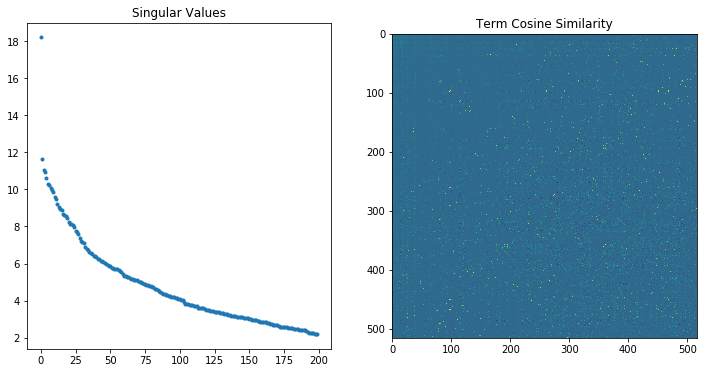

In [301]:
# scipy SVD to compute term similarity
num_comp = 200

# get dense tfidf matrix to do SVD in scipy to compare word similarities
mat_tfidf = gs.matutils.corpus2dense(corpus_tfidf, len(dct.dfs))
TSVD = decomposition.TruncatedSVD(n_components=num_comp)
TSVD.fit_transform(mat_tfidf.T)
U = TSVD.components_
TSVD.fit_transform(mat_tfidf)
V = TSVD.components_
S = np.diag(TSVD.singular_values_)

# get transformed word vectors
# QUESTION: why multiply by the singular values here?
# U is an unitary matrix (N_t x k), therefore >np.matmul(U,U.T) == metrics.pairwise.cosine_similarity(U)
#    columns of U are the bases of the projected space, and multiplying by S gives the weighted length?
#
# X_star is the low dimensional approximation of X, so X_star*X_star.T gives the covariance matrix of 
#    the low-d term vectors. U is the "term" basis matrix in the low-D projection space, U*S gives the actual 
#    projected length of each term vector in the low-D space.
# S stretches the low-D basis (k space) differently for each k, i.e. it emphasises some dimensions
# conceptually, if one dimension is way more important than the others, than scaling it more will
# emphasize differences/similiarities along that axis only
t_star = np.matmul(S,U).T

# word similarity from raw tfidf matrix
term_sim_raw = metrics.pairwise.cosine_similarity(mat_tfidf) 
# word similarity from LSA transformed matrix
term_sim_LSA = metrics.pairwise.cosine_similarity(t_star)
print('Term Similarity Matrix: (%i, %i)'%term_sim_LSA.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(TSVD.singular_values_, '.')
plt.title('Singular Values')
plt.subplot(1,2,2)
plt.imshow(term_sim_LSA - sp.eye(term_sim_LSA.shape[0]))
plt.title('Term Cosine Similarity')

In [296]:
terms_similar_to(term_sim_LSA, dct, 'working memory', 20)

Freq. | Similarity: Term
------------------------
0.032 | 1.000: working memory
0.002 | 0.622: spatial working memory
0.001 | 0.550: phonological loop
0.000 | 0.497: central executive
0.000 | 0.494: phonological working memory
0.000 | 0.475: interference control
0.121 | 0.441: memory
0.000 | 0.426: interference resolution
0.002 | 0.420: visual working memory
0.000 | 0.394: working memory updating
0.000 | 0.382: gestalt grouping
0.001 | 0.379: cognitive training
0.001 | 0.350: change blindness
0.000 | 0.337: semantic working memory
0.000 | 0.309: color perception
0.001 | 0.303: response selection
0.000 | 0.291: attentional state
0.001 | 0.285: phonological awareness
0.001 | 0.271: fluid intelligence
0.000 | 0.263: contingency learning


### Clustering

[41, 12, 17, 12, 11, 17, 16, 41, 11, 21, 15, 302]


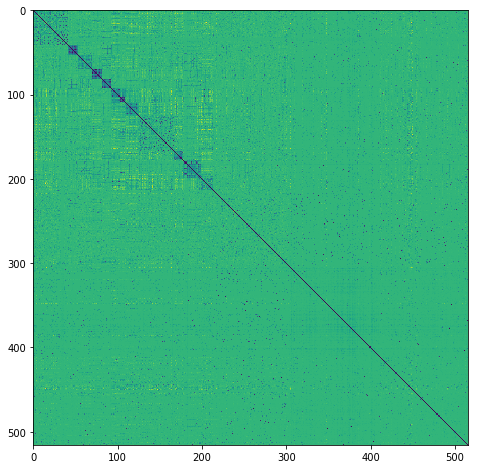

In [407]:
# because transformed word vectors can be negative, apply heat kernel:
#      similarity = np.exp(-beta * distance / distance.std())
beta=0.001
n_clusters = 12
term_dist_LSA = 1.-term_sim_LSA
clu = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')

clu.fit(np.exp(-(beta/term_dist_LSA.std())*term_dist_LSA))
clu_label = clu.labels_

#clu_label = clu.fit(np.exp(-beta * (1.-term_sim_LSA)/(1.-term_sim_LSA).std()))
clu_inds = np.argsort(clu_label)
plt.figure(figsize=(8,8))
plt.imshow(term_dist_LSA[clu_inds,:][:,clu_inds])
print([len(np.where(clu_label==c)[0]) for c in range(n_clusters)])
clustered_terms = [[dct.id2token[i] for i in np.where(clu_label==query_clu)[0]] for query_clu in range(n_clusters)]

In [408]:
pd.DataFrame([t[:10] for t in clustered_terms], index=['Clu%i'%i for i in range(n_clusters)])

,0,1,2,3,4,5,6,7,8,9
Clu0,intelligence,social intelligence,memory,semantic memory,encoding,retrieval,analogical inference,analogical transfer,intonation,syntactic processing
Clu1,conflict detection,inhibition,skepticism,inhibition of return,response conflict,excitation,response inhibition,interrogative,feature integration,response execution
Clu2,attention,focused attention,attentional blink,inattentional blindness,involuntary attention,change blindness,autobiographical memory,availability heuristic,exogenous attention,attention shift
Clu3,explicit memory,implicit memory,consolidation,memory consolidation,sleep,proactive interference,retroactive interference,reconsolidation,dream,delusion
Clu4,detection,response bias,abductive reasoning,visual angle,global precedence,motion detection,object detection,object-based attention,feature detection,error detection
Clu5,centration,declarative memory,stereotypes,emotional expression,emotion perception,fear,worldview,negative emotion,lexical processing,sadness
Clu6,motor program,visual memory,crossmodal,attachment,attentional resources,rehearsal,mental arithmetic,auditory memory,audition,instinct
Clu7,working memory,imagery,mental imagery,planning,false memory,orthography,memory decay,past tense,pronunciation,text processing
Clu8,maintenance,processing capacity,sensory memory,curiosity,attentional bias,active maintenance,intrinsic motivation,response selection,metamemory,novelty detection
Clu9,perception,face perception,interoception,object recognition,hallucination,grapheme,object perception,visual object recognition,color perception,subconscious


### word2vec!!!